# shap

In [31]:
import pandas as pd
import xgboost as xgb
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import Binarizer
import shap

# 载入数据
train_data = pd.read_csv('train.csv')


# kmeans = KMeans(n_clusters=3)
# train_data['Cluster'] = kmeans.fit_predict(train_data[['Age', 'Fare']])

binarizer = Binarizer(threshold=0.0)
train_data['High_Fare'] = binarizer.fit_transform(train_data[['Fare']])

train_data['Young_and_Rich'] = np.where((train_data['Age'] < 30) & (train_data['Fare'] > 50), 1, 0)
# 更多类似的特征...

# 特征1：年龄和船舱等级的乘积
train_data['Age_Pclass'] = train_data['Age'] * train_data['Pclass']

# 特征2：是否为成年人
train_data['IsAdult'] = train_data['Age'] >= 18

# 特征3-10：其他示例特征
train_data['Age_Squared'] = train_data['Age'] ** 2
train_data['Fare_Squared'] = train_data['Fare'] ** 2
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch']
train_data['IsAlone'] = train_data['Family_Size'] == 0
train_data['Fare_Per_Person'] = train_data['Fare'] / (train_data['Family_Size'] + 1)
train_data['Age_Times_Fare'] = train_data['Age'] * train_data['Fare']
train_data['Age_Category'] = pd.cut(train_data['Age'], bins=[0, 12, 18, 60, 100], labels=['Child', 'Teen', 'Adult', 'Senior'])

train_data['Age^2'] = train_data['Age'] ** 2
train_data['Fare^3'] = train_data['Fare'] ** 3

train_data['Age*Class'] = train_data['Age'] * train_data['Pclass']
train_data['SibSp/Parch'] = train_data['SibSp'] / (train_data['Parch'] + 1)

train_data['IsChild'] = train_data['Age'] < 18
train_data['IsElderly'] = train_data['Age'] > 60

# 如果您有类别型特征如'Embarked'
# train_data = pd.get_dummies(train_data, columns=['Embarked', 'Sex'])
# 这将创建多个特征...



# 假设您有类别型特征如'Embarked'
train_data['AverageFarePerClass'] = train_data.groupby('Pclass')['Fare'].transform('mean')
train_data['MedianAgePerClass'] = train_data.groupby('Pclass')['Age'].transform('median')
# 更多类似的特征...

train_data['Log_Fare'] = np.log(train_data['Fare'] + 1)
train_data['Sqrt_Age'] = np.sqrt(train_data['Age'])

# 数据预处理
# 简化为使用几个特征：'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'
# train_data = train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].dropna()

# 将'性别'这一列从字符串转换为数字
train_data['Sex'] = LabelEncoder().fit_transform(train_data['Sex'])


# train_data['FamilyType'] = pd.cut(train_data['FamilySize'], bins=[0, 1, 4, 7, 11], labels=['Solo', 'Small', 'Medium', 'Large'])
train_data['AgePclass'] = train_data['Age'] * train_data['Pclass']

train_data['IsChild'] = train_data['Age'] < 12
train_data['IsSenior'] = train_data['Age'] >= 60

train_data['NameLength'] = train_data['Name'].apply(len)
train_data['HighFareTicket'] = train_data['Fare'] > train_data['Fare'].median()

# train_data['AgeBinAlone'] = pd.cut(train_data[train_data['IsAlone'] == 1]['Age'].astype(int), 5)

from sklearn.preprocessing import LabelEncoder

# 创建标签编码器实例
label_encoder = LabelEncoder()

# 对每个列进行检查和转换
for col in train_data.columns:
    if train_data[col].dtype == 'object' or train_data[col].dtype.name == 'category':
        # 训练集标签编码
        train_data[col] = label_encoder.fit_transform(train_data[col].astype(str))
        

# for col in train_data.columns:
#     if train_data[col].dtype == 'object' or train_data[col].dtype.name == 'category':
#         # 合并训练集和测试集
#         # combined = pd.concat([train_data[col], X_test[col]], axis=0)
        
#         # 应用标签编码
#         combined_encoded = label_encoder.fit_transform(train_data.astype(str))
        
#         # 分离编码后的训练集和测试集
#         train_data[col], X_test[col] = combined_encoded[:len(X_train)], combined_encoded[len(X_train):]

# 定义特征和目标

y = train_data['Survived']
X = train_data.drop(['Survived'],axis=1)


# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练XGBoost模型
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',  enable_categorical=True)
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率: {accuracy * 100.0}%")

# 使用SHAP解释模型
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 初始化一个空的DataFrame来存储SHAP值
all_shap_values = pd.DataFrame(columns=X_train.columns)

# 使用SHAP解释模型
explainer = shap.Explainer(model)
for index in range(len(X_train)):
    # 计算当前样本的SHAP值
    shap_values = explainer(X_train.iloc[index:index+1])

    # 将SHAP值添加到DataFrame
    all_shap_values = all_shap_values.append(pd.DataFrame(shap_values.values, columns=X_train.columns), ignore_index=True)

# 计算每个特征的平均绝对SHAP值
mean_shap_values = np.abs(all_shap_values).mean().sort_values(ascending=False)

# 打印排序后的特征和它们的平均绝对SHAP值
print(mean_shap_values)



模型准确率: 83.79888268156425%


[21:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[21:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Sex                    2.001914
Ticket                 0.700822
Pclass                 0.693239
PassengerId            0.560281
Age_Pclass             0.560134
Name                   0.550420
Fare_Per_Person        0.545075
Age_Times_Fare         0.541281
NameLength             0.387253
Fare                   0.310956
Age                    0.255775
Cabin                  0.239907
Embarked               0.199581
Family_Size            0.147473
SibSp                  0.059599
SibSp/Parch            0.033353
Age_Category           0.016789
Parch                  0.009806
Log_Fare               0.000000
AgePclass              0.000000
IsChild                0.000000
IsSenior               0.000000
MedianAgePerClass      0.000000
AverageFarePerClass    0.000000
IsElderly              0.000000
Sqrt_Age               0.000000
IsAlone                0.000000
Age*Class              0.000000
Fare^3                 0.000000
Age^2                  0.000000
Fare_Squared           0.000000
Age_Squa

In [34]:
df = pd.concat([X_train,X_train,X_train,X_train,X_train])

In [35]:
X_train = df

# 初始化一个空的DataFrame来存储SHAP值
all_shap_values = pd.DataFrame(columns=X_train.columns)

# 使用SHAP解释模型
explainer = shap.Explainer(model)
for index in range(len(X_train)):
    # 计算当前样本的SHAP值
    shap_values = explainer(X_train.iloc[index:index+1])

    # 将SHAP值添加到DataFrame
    all_shap_values = all_shap_values.append(pd.DataFrame(shap_values.values, columns=X_train.columns), ignore_index=True)

# 计算每个特征的平均绝对SHAP值
mean_shap_values = np.abs(all_shap_values).mean().sort_values(ascending=False)

# 打印排序后的特征和它们的平均绝对SHAP值
print(mean_shap_values)

[21:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Sex                    2.001914
Ticket                 0.700822
Pclass                 0.693239
PassengerId            0.560281
Age_Pclass             0.560134
Name                   0.550420
Fare_Per_Person        0.545075
Age_Times_Fare         0.541281
NameLength             0.387253
Fare                   0.310956
Age                    0.255775
Cabin                  0.239907
Embarked               0.199581
Family_Size            0.147473
SibSp                  0.059599
SibSp/Parch            0.033353
Age_Category           0.016789
Parch                  0.009806
Log_Fare               0.000000
AgePclass              0.000000
IsChild                0.000000
IsSenior               0.000000
MedianAgePerClass      0.000000
AverageFarePerClass    0.000000
IsElderly              0.000000
Sqrt_Age               0.000000
IsAlone                0.000000
Age*Class              0.000000
Fare^3                 0.000000
Age^2                  0.000000
Fare_Squared           0.000000
Age_Squa

In [37]:
X_train = df

# 初始化一个空的DataFrame来存储SHAP值
all_shap_values = pd.DataFrame(columns=X_train.columns)

# 使用SHAP TreeExplainer解释模型
explainer = shap.TreeExplainer(model)
for index in range(len(X_train)):
    # 计算当前样本的SHAP值
    shap_values = explainer.shap_values(X_train.iloc[index:index+1])

    # 将SHAP值添加到DataFrame
    all_shap_values = all_shap_values.append(pd.DataFrame(shap_values, columns=X_train.columns), ignore_index=True)
# 计算每个特征的平均绝对SHAP值
mean_shap_values = np.abs(all_shap_values).mean().sort_values(ascending=False)

# 打印排序后的特征和它们的平均绝对SHAP值
print(mean_shap_values)

[21:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Sex                    2.001914
Ticket                 0.700822
Pclass                 0.693239
PassengerId            0.560281
Age_Pclass             0.560134
Name                   0.550420
Fare_Per_Person        0.545075
Age_Times_Fare         0.541281
NameLength             0.387253
Fare                   0.310956
Age                    0.255775
Cabin                  0.239907
Embarked               0.199581
Family_Size            0.147473
SibSp                  0.059599
SibSp/Parch            0.033353
Age_Category           0.016789
Parch                  0.009806
Log_Fare               0.000000
AgePclass              0.000000
IsChild                0.000000
IsSenior               0.000000
MedianAgePerClass      0.000000
AverageFarePerClass    0.000000
IsElderly              0.000000
Sqrt_Age               0.000000
IsAlone                0.000000
Age*Class              0.000000
Fare^3                 0.000000
Age^2                  0.000000
Fare_Squared           0.000000
Age_Squa

In [48]:
# import fastshap
# from fastshap import FastSHAP, Surrogate

# # 假设 model 是已经训练好的模型
# # model = ...

# # 创建 FastSHAP 对象
# surrogate = fastshap.Surrogate(model.predict, X_train)
# explainer = FastSHAP(surrogate, X_train, model_output='raw', link='identity')

# # 训练 FastSHAP 解释器
# explainer.train(X_train, batch_size=32, num_samples=128, max_epochs=5)

# # 使用 FastSHAP 计算 SHAP 值
# shap_values_fast = explainer.shap_values(X_train)


In [49]:
import fasttreeshap

explainer = fasttreeshap.YourFastTreeShapClass(model)  # 使用适当的类名和参数

# 计算 SHAP 值
shap_values = explainer.shap_values(X_train)

# 进行可视化
# 这里可以使用标准的 SHAP 可视化方法
shap.summary_plot(shap_values, X_train)

AttributeError: module 'fasttreeshap' has no attribute 'YourFastTreeShapClass'

In [50]:
import fasttreeshap
print(fasttreeshap.__file__)


/Users/ren/Desktop/karen/git_karen/Notes/.venv/lib/python3.9/site-packages/fasttreeshap/__init__.py


In [47]:
! pip install fasttreeshap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.1/339.1 kB 1.0 MB/s eta 0:00:0000:0100:01m


In [41]:
! pip install fastshap

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=20bd1d3acbb40c7bd196bf1ca49c113275eab28cd8d7a28c609558b935e108c3
  Stored in directory: /Users/ren/Library/Caches/pip/wheels/9e/9e/4c/184e84f4ce918378a9ec9adafd1b6b73bea45f0a4a7855b6ce
Successfully built sklearn


In [40]:
all_shap_values.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,High_Fare,Young_and_Rich,Age_Pclass,IsAdult,Age_Squared,Fare_Squared,Family_Size,IsAlone,Fare_Per_Person,Age_Times_Fare,Age_Category,Age^2,Fare^3,Age*Class,SibSp/Parch,IsChild,IsElderly,AverageFarePerClass,MedianAgePerClass,Log_Fare,Sqrt_Age,AgePclass,IsSenior,NameLength,HighFareTicket
0,-0.290055,0.387821,-0.401779,-2.271473,-0.070081,0.022092,0.003335,0.028838,-0.006089,-0.576793,-0.037005,0.0,0.0,-0.598444,0.0,0.0,0.0,-0.005968,0.0,0.728791,-0.157104,0.005047,0.0,0.0,0.0,0.006516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.780162,0.0


In [32]:
all_shap_values.haed()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,High_Fare,Young_and_Rich,Age_Pclass,IsAdult,Age_Squared,Fare_Squared,Family_Size,IsAlone,Fare_Per_Person,Age_Times_Fare,Age_Category,Age^2,Fare^3,Age*Class,SibSp/Parch,IsChild,IsElderly,AverageFarePerClass,MedianAgePerClass,Log_Fare,Sqrt_Age,AgePclass,IsSenior,NameLength,HighFareTicket
0,-0.290055,0.387821,-0.401779,-2.271473,-0.070081,0.022092,0.003335,0.028838,-0.006089,-0.576793,-0.037005,0.0,0.0,-0.598444,0.0,0.0,0.0,-0.005968,0.0,0.728791,-0.157104,0.005047,0.0,0.0,0.0,0.006516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.780162,0.0
1,-0.398784,0.514655,0.563967,-1.988147,-0.735680,0.020056,0.002316,0.011203,0.216890,-0.110175,-0.253167,0.0,0.0,-0.639324,0.0,0.0,0.0,0.014899,0.0,-0.579619,-1.246767,0.017306,0.0,0.0,0.0,0.014866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.100394,0.0
2,-0.903631,-0.294933,-0.818303,-1.188261,0.005583,0.033791,0.001598,1.601945,0.217459,-0.090499,-0.016976,0.0,0.0,0.904061,0.0,0.0,0.0,0.070211,0.0,-0.519162,-0.276666,0.002863,0.0,0.0,0.0,0.012154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.191189,0.0
3,-0.528132,-0.303343,0.077263,-1.060468,0.690647,0.024361,0.002058,-0.945823,0.116080,-0.106455,-0.240856,0.0,0.0,0.149626,0.0,0.0,0.0,0.061152,0.0,-0.936087,-0.542106,0.006475,0.0,0.0,0.0,-0.073992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.169785,0.0
4,-0.922760,-1.174847,-0.120156,0.954723,-0.351690,-0.202128,-0.021481,-1.134293,-0.315236,-0.041375,-0.104842,0.0,0.0,0.398264,0.0,0.0,0.0,-1.576874,0.0,-0.189633,-0.697595,-0.015303,0.0,0.0,0.0,-0.183173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074399,0.0
5,-1.898264,0.379272,0.941392,-1.741365,-0.531118,0.057921,0.002092,-0.956662,-0.042411,0.527270,0.380000,0.0,0.0,0.193565,0.0,0.0,0.0,0.065172,0.0,0.573007,-0.369247,0.006909,0.0,0.0,0.0,0.036953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.523767,0.0
6,-0.446407,0.426748,-0.383829,-1.809135,0.010309,0.012124,0.003451,-0.340607,-0.027980,0.013300,-0.141816,0.0,0.0,-0.495895,0.0,0.0,0.0,0.024504,0.0,0.547942,-0.105229,0.017306,0.0,0.0,0.0,0.012422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850042,0.0
7,-0.566650,0.453955,-1.579051,-2.418385,-0.088316,0.020297,0.003335,0.369403,-0.302425,-0.127633,0.678014,0.0,0.0,-0.880119,0.0,0.0,0.0,0.025564,0.0,-0.279023,-0.598977,0.005489,0.0,0.0,0.0,-0.036561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.229769,0.0
8,0.971481,-0.261889,-0.653239,-1.411629,0.022591,0.032088,0.002152,-1.526739,0.006623,-0.204487,-0.076108,0.0,0.0,-0.115738,0.0,0.0,0.0,0.034833,0.0,-0.694710,-0.168219,-0.015354,0.0,0.0,0.0,-0.004083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.162600,0.0
9,0.963752,0.366695,-0.718398,-1.343109,0.478934,0.021808,0.002120,1.867453,-0.181084,0.764070,-0.061476,0.0,0.0,0.430241,0.0,0.0,0.0,0.038052,0.0,0.917840,0.120643,-0.015354,0.0,0.0,0.0,0.008265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.282481,0.0


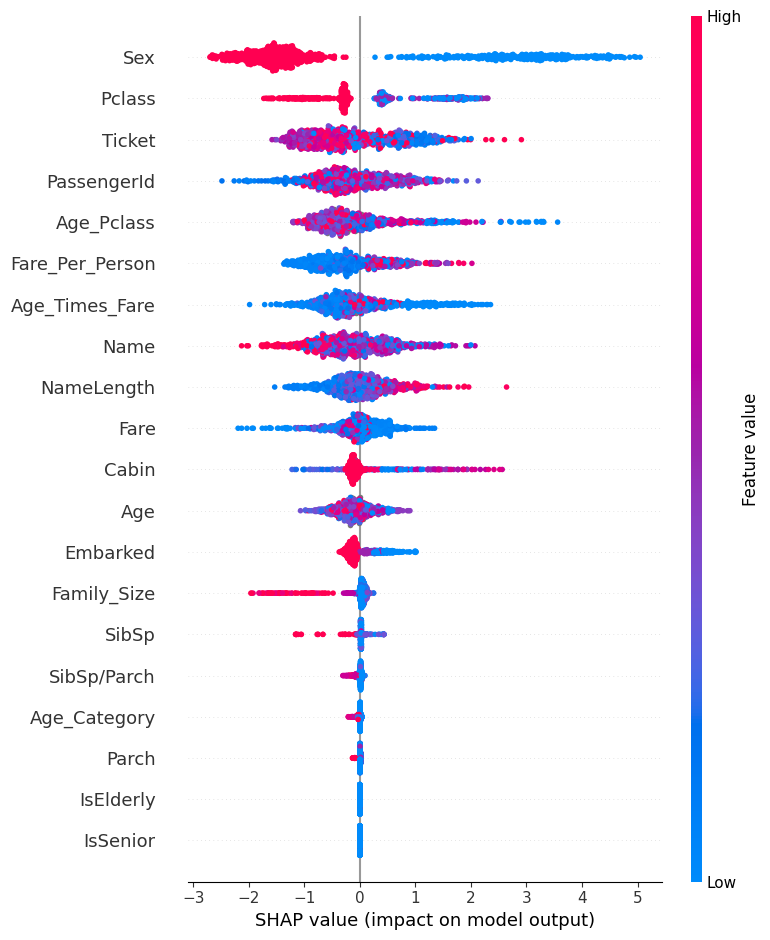

In [27]:
shap.summary_plot(shap_values, X)

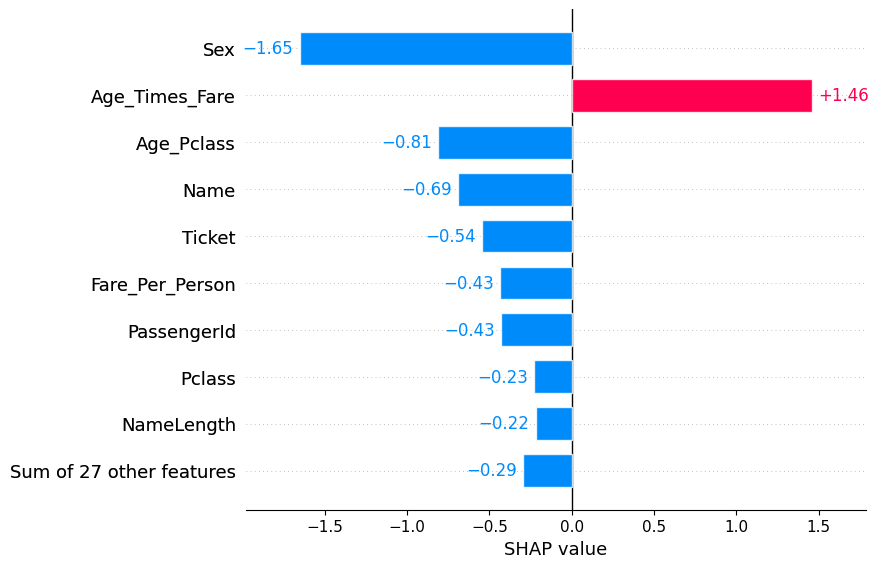

In [25]:
# 选择一个样本进行展示
shap.plots.bar(shap_values[0])


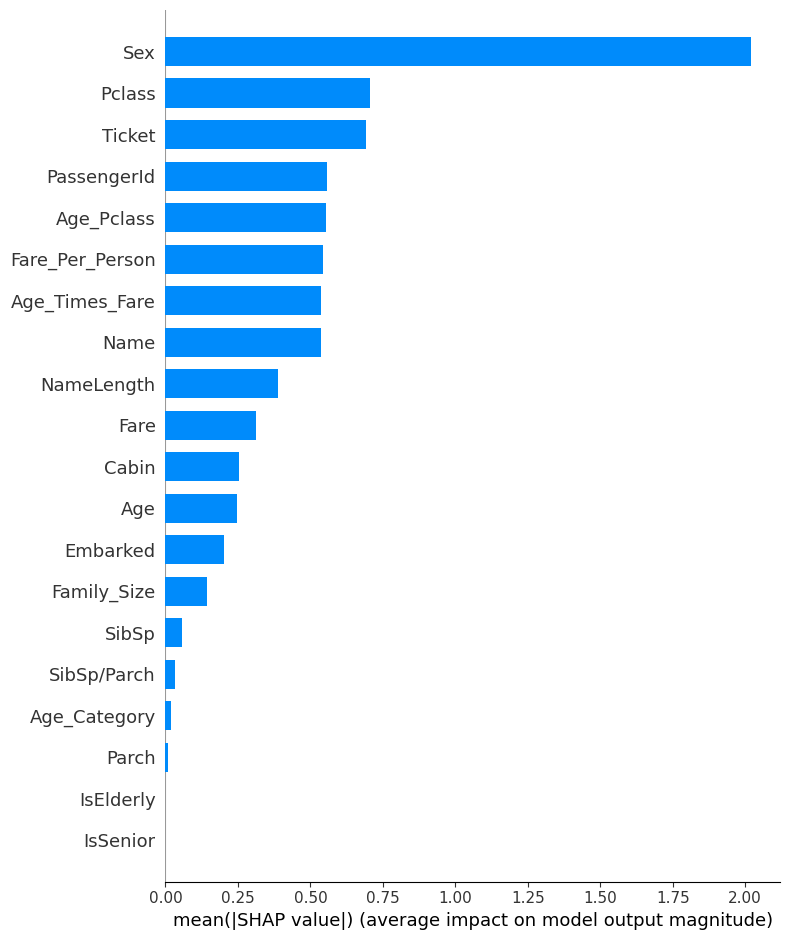

In [26]:
# 展示整个数据集的SHAP值条形图
shap.summary_plot(shap_values, X, plot_type="bar")


In [3]:
import pandas as pd

# 设置Pandas以便全屏显示DataFrame
pd.set_option('display.max_rows', None)  # 不限制显示的行数
pd.set_option('display.max_columns', None)  # 不限制显示的列数
pd.set_option('display.width', None)  # 自动调整列宽
pd.set_option('display.max_colwidth', None)  # 不限制列

In [61]:
X.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,High_Fare,Young_and_Rich,Age_Pclass,IsAdult,Age_Squared,Fare_Squared,Family_Size,IsAlone,Fare_Per_Person,Age_Times_Fare,Age_Category,Age^2,Fare^3,Age*Class,SibSp/Parch,IsChild,IsElderly,AverageFarePerClass,MedianAgePerClass,Log_Fare,Sqrt_Age,AgePclass,IsSenior,NameLength,HighFareTicket
0,1,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0,0,66.0,True,484.0,52.562500,1,False,3.62500,159.5000,Adult,484.0,381.078125,66.0,1.0,False,False,13.675550,24.0,2.110213,4.690416,66.0,False,23,False
1,2,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0,38.0,True,1444.0,5081.308859,1,False,35.64165,2708.7654,Adult,1444.0,362212.463781,38.0,1.0,False,False,84.154687,37.0,4.280593,6.164414,38.0,False,51,True


In [53]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare
331,1,1,45.5,0,0,28.5000
733,2,1,23.0,0,0,13.0000
382,3,1,32.0,0,0,7.9250
704,3,1,26.0,1,0,7.8542
813,3,0,6.0,4,2,31.2750
...,...,...,...,...,...,...
106,3,0,21.0,0,0,7.6500
270,1,1,NaN,0,0,31.0000
860,3,1,41.0,2,0,14.1083
435,1,0,14.0,1,2,120.0000


In [4]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# 载入数据
train_data = pd.read_csv('train.csv')

# 数据预处理
train_data = train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].dropna()
train_data['Sex'] = LabelEncoder().fit_transform(train_data['Sex'])

# 定义特征和目标
X = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = train_data['Survived']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练XGBoost模型
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 使用SHAP解释模型
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 输出每个乘客的SHAP值（此处仅显示前10个样本）
for i in range(10):
    print(f"乘客 {i} 的SHAP值:")
    print(shap_values[i])


[13:39:23] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


乘客 0 的SHAP值:
.values =
array([-0.71240056, -1.8701689 , -0.4637064 , -0.36828575, -0.08383776,
       -0.3688765 ], dtype=float32)

.base_values =
-0.41325763

.data =
array([ 3.  ,  1.  , 22.  ,  1.  ,  0.  ,  7.25])
乘客 1 的SHAP值:
.values =
array([ 2.0296254 ,  2.8582227 , -0.4093648 , -0.08029366, -0.0299821 ,
        1.8410202 ], dtype=float32)

.base_values =
-0.41325763

.data =
array([ 1.    ,  0.    , 38.    ,  1.    ,  0.    , 71.2833])
乘客 2 的SHAP值:
.values =
array([-1.0770906 ,  2.1722236 , -0.5393392 ,  0.40246335, -0.15825137,
        0.14075842], dtype=float32)

.base_values =
-0.41325763

.data =
array([ 3.   ,  0.   , 26.   ,  0.   ,  0.   ,  7.925])
乘客 3 的SHAP值:
.values =
array([ 2.3619354 ,  2.823069  ,  0.9620637 , -0.17915185, -0.00720201,
        2.2154748 ], dtype=float32)

.base_values =
-0.41325763

.data =
array([ 1. ,  0. , 35. ,  1. ,  0. , 53.1])
乘客 4 的SHAP值:
.values =
array([-0.9989797 , -1.0065747 , -1.1864804 ,  0.20817547, -0.01537037,
        0.25038168], 

[14:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


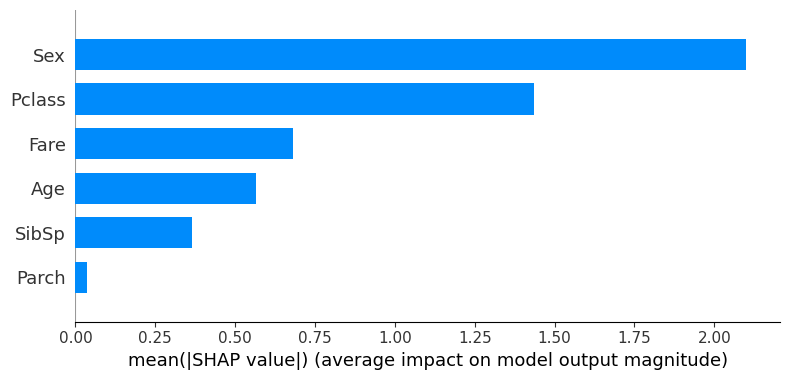

Sex       2.100731
Pclass    1.434398
Fare      0.680517
Age       0.566722
SibSp     0.363899
Parch     0.037407
dtype: float32


In [40]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 载入数据
train_data = pd.read_csv('train.csv')

# 特征1：年龄和船舱等级的乘积
train_data['Age_Pclass'] = train_data['Age'] * train_data['Pclass']

# 特征2：是否为成年人
train_data['IsAdult'] = train_data['Age'] >= 18

# 特征3-10：其他示例特征
train_data['Age_Squared'] = train_data['Age'] ** 2
train_data['Fare_Squared'] = train_data['Fare'] ** 2
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch']
train_data['IsAlone'] = train_data['Family_Size'] == 0
train_data['Fare_Per_Person'] = train_data['Fare'] / (train_data['Family_Size'] + 1)
train_data['Age_Times_Fare'] = train_data['Age'] * train_data['Fare']
train_data['Age_Category'] = pd.cut(train_data['Age'], bins=[0, 12, 18, 60, 100], labels=['Child', 'Teen', 'Adult', 'Senior'])



# 数据预处理
train_data = train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].dropna()
train_data['Sex'] = LabelEncoder().fit_transform(train_data['Sex'])

# 定义特征和目标
X = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = train_data['Survived']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练XGBoost模型
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 使用SHAP解释模型
explainer = shap.Explainer(model)
shap_values = explainer(X_train.head(1))

# 绘制摘要图表
shap.summary_plot(shap_values, X_train, plot_type="bar")

shap_values_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

# 计算每个特征的平均绝对SHAP值
mean_shap_values = np.abs(shap_values_df).mean().sort_values(ascending=False)

# 打印排序后的特征和它们的平均绝对SHAP值
print(mean_shap_values)

# # 使用SHAP解释模型
# explainer = shap.Explainer(model)
# shap_values = explainer(X_train)



In [41]:
# 初始化一个空的DataFrame来存储SHAP值
all_shap_values = pd.DataFrame(columns=X_train.columns)

# 使用SHAP解释模型
explainer = shap.Explainer(model)

# 循环遍历X_train中的每个样本
for index in range(len(X_train)):
    # 计算当前样本的SHAP值
    shap_values = explainer(X_train.iloc[index:index+1])

    # 将SHAP值添加到DataFrame
    all_shap_values = all_shap_values.append(pd.DataFrame(shap_values.values, columns=X_train.columns), ignore_index=True)

# 计算每个特征的平均绝对SHAP值
mean_shap_values = np.abs(all_shap_values).mean().sort_values(ascending=False)

# 打印排序后的特征和它们的平均绝对SHAP值
print(mean_shap_values)

[14:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Sex       1.788905
Age       1.153560
Pclass    1.064456
Fare      0.945333
SibSp     0.309021
Parch     0.106280
dtype: float32


In [43]:
all_shap_values.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare
0,-1.434398,2.100731,0.566722,-0.363899,-0.037407,0.680517
1,-0.898143,-1.030900,-1.072957,-0.541242,-0.042011,-0.801948
2,-0.886367,-0.847419,-0.417839,-0.317983,-0.115881,-0.436756
